In [47]:
import pandas as pd
import numpy as np
import skimage.io as sk
from skimage import img_as_ubyte
from skimage.io import imread
from scipy import spatial
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda, MaxPooling2D, Conv2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import os
import glob
import pickle

import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
from scipy import ndimage
from skimage.measure import regionprops
from skimage import io
from skimage.filters import threshold_otsu   # For finding the threshold for grayscale to binary conversion
import tensorflow as tf
import pandas as pd
import numpy as np
from time import time
import keras
from keras.utils import np_utils
from tensorflow.python.framework import ops

In [2]:
CurrentWorkingDir = os.path.dirname(os.getcwd())
CurrentWorkingDir = os.path.join(CurrentWorkingDir,"PI/newdata")
print(CurrentWorkingDir)

/home/mehdi/Bureau/PI/newdata


In [3]:
GeniuneDirectory = os.path.join(CurrentWorkingDir,"real")

In [4]:
#Creating Geniune Signature Data Path
dataset_path = GeniuneDirectory
checks_geniune = os.path.join(dataset_path,'*')
checks_geniune = glob.glob(checks_geniune)
print(checks_geniune)
print(GeniuneDirectory)

['/home/mehdi/Bureau/PI/newdata/real/Real_014_09.PNG', '/home/mehdi/Bureau/PI/newdata/real/Real_009_18.PNG', '/home/mehdi/Bureau/PI/newdata/real/Real_015_09.PNG', '/home/mehdi/Bureau/PI/newdata/real/009009_002.png', '/home/mehdi/Bureau/PI/newdata/real/Real_004_05.PNG', '/home/mehdi/Bureau/PI/newdata/real/Real_006_09.PNG', '/home/mehdi/Bureau/PI/newdata/real/Real_006_21.PNG', '/home/mehdi/Bureau/PI/newdata/real/Real_004_11.PNG', '/home/mehdi/Bureau/PI/newdata/real/Real_001_18.PNG', '/home/mehdi/Bureau/PI/newdata/real/Real_003_01.PNG', '/home/mehdi/Bureau/PI/newdata/real/Real_006_12.PNG', '/home/mehdi/Bureau/PI/newdata/real/Real_012_04.PNG', '/home/mehdi/Bureau/PI/newdata/real/Real_016_01.PNG', '/home/mehdi/Bureau/PI/newdata/real/Real_001_21.PNG', '/home/mehdi/Bureau/PI/newdata/real/Real_006_16.PNG', '/home/mehdi/Bureau/PI/newdata/real/001001_003.png', '/home/mehdi/Bureau/PI/newdata/real/003003_001.png', '/home/mehdi/Bureau/PI/newdata/real/Real_006_17.PNG', '/home/mehdi/Bureau/PI/newdata

In [5]:
ForgedDirectory = os.path.join(CurrentWorkingDir,"forged")
print(ForgedDirectory)

/home/mehdi/Bureau/PI/newdata/forged


In [6]:
print(ForgedDirectory)

/home/mehdi/Bureau/PI/newdata/forged


In [7]:
#Creating Forged Signature Data Path
dataset_path = ForgedDirectory
checks_forged = os.path.join(dataset_path,'*')
checks_forged = glob.glob(checks_forged)
print(checks_forged[0])

/home/mehdi/Bureau/PI/newdata/forged/Forged_003_01.png


In [8]:
print(len(checks_geniune))
print(len(checks_forged))

299
183


## Applying Preprocessing

In [9]:
def rgbgrey(img):
    # Converts rgb to grayscale
    greyimg = np.zeros((img.shape[0], img.shape[1]))
    for row in range(len(img)):
        for col in range(len(img[row])):
            greyimg[row][col] = np.average(img[row][col])
    return greyimg

def greybin(img):
    # Converts grayscale to binary
    blur_radius = 0.8
    img = ndimage.gaussian_filter(img, blur_radius)  # to remove small components or noise
#     img = ndimage.binary_erosion(img).astype(img.dtype)
    thres = threshold_otsu(img)
    binimg = img > thres
    binimg = np.logical_not(binimg)
    return binimg


def preproc(path, img=None, display=True):
    if img is None:
        img = mpimg.imread(path)
    if display:
        plt.imshow(img)
        plt.show()
    grey = rgbgrey(img) #rgb to grey
    if display:
        plt.imshow(grey, cmap = matplotlib.cm.Greys_r)
        plt.show()
    binimg = greybin(grey) #grey to binary
    if display:
        plt.imshow(binimg, cmap = matplotlib.cm.Greys_r)
        plt.show()
    r, c = np.where(binimg==1)
    # Now we will make a bounding box with the boundary as the position of pixels on extreme.
    # Thus we will get a cropped image with only the signature part.
    signimg = binimg[r.min(): r.max(), c.min(): c.max()]
    if display:
        plt.imshow(signimg, cmap = matplotlib.cm.Greys_r)
        plt.show()
    return signimg

## Creating Model CNN

In [54]:
Image_Width = 512
Image_Height = 512
Image_Size = (Image_Width, Image_Height)
Image_Channel = 3
batch_size=15

In [55]:
model = Sequential()

## Conv layer 1
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(Image_Width,Image_Height, Image_Channel)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

## Conv layer 2
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

## Conv layer 3
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

## Conv layer 4
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

## Conv layer 5
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

## Conv layer 6
model.add(Conv2D(512, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [56]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 510, 510, 32)      896       
                                                                 
 batch_normalization_14 (Bat  (None, 510, 510, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 255, 255, 32)     0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 255, 255, 32)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 253, 253, 64)      18496     
                                                                 
 batch_normalization_15 (Bat  (None, 253, 253, 64)    

In [57]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
callbacks = [early_stop, learning_rate_reduction]

# Data Augmentation

In [58]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                  rescale=1./255,
                                  shear_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,)

In [59]:
train_generator = train_datagen.flow_from_directory('/home/mehdi/Bureau/PI/newdata',
                                              target_size=Image_Size,
                                              batch_size=32,
                                              class_mode = 'categorical')


Found 482 images belonging to 2 classes.


In [60]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [61]:
test_generator = test_datagen.flow_from_directory('/home/mehdi/Bureau/PI/SignaturesDataTest',
                                                  target_size=Image_Size,
                                                  batch_size = 32,
                                                  class_mode='categorical')

Found 263 images belonging to 2 classes.


In [62]:
epochs = 10
history = model.fit_generator(train_generator,
                             epochs=epochs,
                             validation_data=test_generator,
                             validation_steps=len(test_generator),
                             steps_per_epoch=len(train_generator),
                             callbacks=callbacks)

/home/mehdi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10
16/16 [==============================] - 160s 10s/step - loss: 1.0932 - accuracy: 0.6224 - val_loss: 0.7747 - val_accuracy: 0.3194 - lr: 0.0010
Epoch 2/10
16/16 [==============================] - -3433s -229573374us/step - loss: 0.8310 - accuracy: 0.6618 - val_loss: 4.9417 - val_accuracy: 0.3194 - lr: 0.0010
Epoch 3/10
16/16 [==============================] - 169s 10s/step - loss: 0.6280 - accuracy: 0.7386 - val_loss: 2.5854 - val_accuracy: 0.3194 - lr: 0.0010
Epoch 4/10
16/16 [==============================] - 165s 10s/step - loss: 0.7017 - accuracy: 0.7407 - val_loss: 8.9562 - val_accuracy: 0.3194 - lr: 0.0010
Epoch 5/10
16/16 [==============================] - 169s 11s/step - loss: 0.6121 - accuracy: 0.7614 - val_loss: 12.2176 - val_accuracy: 0.3194 - lr: 0.0010
Epoch 6/10
16/16 [==============================] - 177s 11s/step - loss: 0.5107 - accuracy: 0.7842 - val_loss: 8.8466 - val_accuracy: 0.3194 - lr: 0.0010
Epoch 7/10
16/16 [==============================] - 172s 1

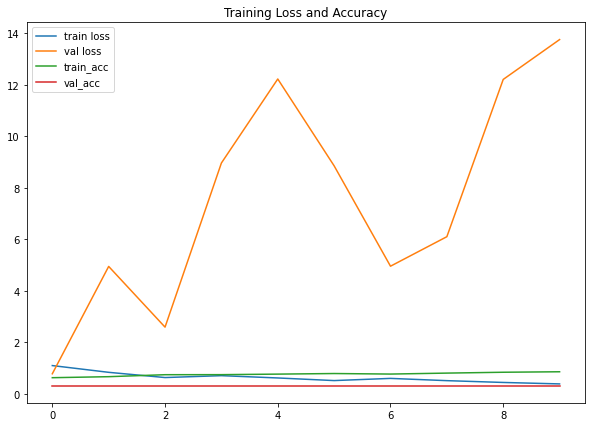

[0.6224066615104675, 0.6618257164955139, 0.7385892271995544, 0.7406638860702515, 0.7614107728004456, 0.7842323780059814, 0.7634854912757874, 0.8008298873901367, 0.8340249061584473, 0.8526970744132996]


<Figure size 432x288 with 0 Axes>

In [63]:
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Training Loss and Accuracy")
plt.legend()
plt.show()
plt.savefig('lossval_loss')
print(history.history['accuracy'])

In [64]:
print(model.outputs)

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_5')>]


In [65]:
pred = model.predict(test_generator)
pred

array([[1.33632827e-09, 1.00000000e+00],
       [7.81658960e-10, 1.00000000e+00],
       [9.03155273e-10, 1.00000000e+00],
       [2.95071967e-10, 1.00000000e+00],
       [1.06233966e-09, 1.00000000e+00],
       [2.69639949e-10, 1.00000000e+00],
       [1.16753096e-09, 1.00000000e+00],
       [1.19677168e-09, 1.00000000e+00],
       [7.90024102e-10, 1.00000000e+00],
       [1.41557770e-08, 1.00000000e+00],
       [3.48747697e-10, 1.00000000e+00],
       [4.38815623e-10, 1.00000000e+00],
       [2.94165692e-09, 1.00000000e+00],
       [2.37321167e-08, 1.00000000e+00],
       [1.17597676e-09, 1.00000000e+00],
       [1.49809321e-09, 1.00000000e+00],
       [1.18670884e-09, 1.00000000e+00],
       [1.58481772e-09, 1.00000000e+00],
       [2.33827202e-09, 1.00000000e+00],
       [5.03726127e-09, 1.00000000e+00],
       [9.74699654e-10, 1.00000000e+00],
       [2.20524266e-09, 1.00000000e+00],
       [2.99359870e-10, 1.00000000e+00],
       [9.66124403e-10, 1.00000000e+00],
       [1.839968

In [66]:
import numpy as np
pred = np.argmax(pred, axis=1)
pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [68]:
from tensorflow.keras.models import load_model

model.save('forge_real_signature_model.h5')

In [69]:
model = load_model('forge_real_signature_model.h5')

In [70]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

img = image.load_img('/home/mehdi/Bureau/PI/newdata/real/001001_000.png', target_size=(512,512))
x = image.img_to_array(img)
x=x/255
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape
model.predict(img_data)
a=np.argmax(model.predict(img_data), axis=1)
print(a)
if(a==1):
    print("The signature is not fraud")
else:
    print("The signature is fraud")
    


[0]
The signature is fraud


In [71]:
for path in checks_geniune:
    img = image.load_img(path, target_size=(512,512))
    x = image.img_to_array(img)
    x=x/255
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    img_data.shape
    model.predict(img_data)
    a=np.argmax(model.predict(img_data), axis=1)
    if(a==1):
        print("The signature is not fraud")
    else:
        print("The signature is fraud")

The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud
The signature is fraud


KeyboardInterrupt: 

## Feature Extraction

In [72]:
def Ratio(img):
    a = 0
    for row in range(len(img)):
        for col in range(len(img[0])):
            if img[row][col]==True:
                a = a+1
    total = img.shape[0] * img.shape[1]
    return a/total

def Centroid(img):
    numOfWhites = 0
    a = np.array([0,0])
    for row in range(len(img)):
        for col in range(len(img[0])):
            if img[row][col]==True:
                b = np.array([row,col])
                a = np.add(a,b)
                numOfWhites += 1
    rowcols = np.array([img.shape[0], img.shape[1]])
    centroid = a/numOfWhites
    centroid = centroid/rowcols
    return centroid[0], centroid[1]

def EccentricitySolidity(img):
    r = regionprops(img.astype("int8"))
    return r[0].eccentricity, r[0].solidity

def SkewKurtosis(img):
    h,w = img.shape
    x = range(w)  # cols value
    y = range(h)  # rows value
    #calculate projections along the x and y axes
    xp = np.sum(img,axis=0)
    yp = np.sum(img,axis=1)
    #centroid
    cx = np.sum(x*xp)/np.sum(xp)
    cy = np.sum(y*yp)/np.sum(yp)
    #standard deviation
    x2 = (x-cx)**2
    y2 = (y-cy)**2
    sx = np.sqrt(np.sum(x2*xp)/np.sum(img))
    sy = np.sqrt(np.sum(y2*yp)/np.sum(img))
    
    #skewness
    x3 = (x-cx)**3
    y3 = (y-cy)**3
    skewx = np.sum(xp*x3)/(np.sum(img) * sx**3)
    skewy = np.sum(yp*y3)/(np.sum(img) * sy**3)

    #Kurtosis
    x4 = (x-cx)**4
    y4 = (y-cy)**4
    # 3 is subtracted to calculate relative to the normal distribution
    kurtx = np.sum(xp*x4)/(np.sum(img) * sx**4) - 3
    kurty = np.sum(yp*y4)/(np.sum(img) * sy**4) - 3

    return (skewx , skewy), (kurtx, kurty)

def getFeatures(path, img=None, display=False):
    if img is None:
        img = mpimg.imread(path)
    img = preproc(path, display=display)
    ratio = Ratio(img)
    centroid = Centroid(img)
    eccentricity, solidity = EccentricitySolidity(img)
    skewness, kurtosis = SkewKurtosis(img)
    retVal = (ratio, centroid, eccentricity, solidity, skewness, kurtosis)
    return retVal

def getCSVFeatures(path, img=None, display=False):
    if img is None:
        img = mpimg.imread(path)
    temp = getFeatures(path, display=display)
    features = (temp[0], temp[1][0], temp[1][1], temp[2], temp[3], temp[4][0], temp[4][1], temp[5][0], temp[5][1])
    return features

# Creating And Saving Features

In [73]:
#Making Feature Extraction
def makeCSV():
    if not(os.path.exists('/home/mehdi/Bureau/PI/Features')):
        os.mkdir('/home/mehdi/Bureau/PI/Features')
        print('New folder "Features" created')
    if not(os.path.exists('/home/mehdi/Bureau/PI/Features/Training')):
        os.mkdir('/home/mehdi/Bureau/PI/Features/Training')
        print('New folder "Features/Training" created')
    if not(os.path.exists('/home/mehdi/Bureau/PI/Features/Testing')):
        os.mkdir('/home/mehdi/Bureau/PI/Features/Testing')
        print('New folder "Features/Testing" created')
    if(len(ForgedDirectory)!=0 and len(GeniuneDirectory)!=0):
        print('Forged and Geniune Paths are not empty')
    for person in range(1,17):
        per = ('00'+str(person))[-3:]
        print('Saving features for person id-',per)
        totalImage = 0
        currentImages=[]
        totalImageG = 0
        currentImagesG=[]
        for path in checks_forged:    
            if(path[-10:-7]==str(per)):
                totalImage = totalImage + 1
                currentImages.append(path)
        for pathg in checks_geniune:
            if(pathg[-10:-7]==str(per)):
                totalImageG = totalImageG + 1
                currentImagesG.append(pathg)
        print("Person :",per,totalImage,totalImageG)
        if(totalImage != 0 and totalImageG !=0):
            with open('/home/mehdi/Bureau/PI/Features/Training/training_'+per+'.csv', 'w') as handle:
                handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y,output\n')
                if (totalImage!=0):
                    for i in range(0,int(totalImage/2)):
                        features = getCSVFeatures(currentImages[i])
                        handle.write(','.join(map(str, features))+',0\n')
                if (totalImageG != 0):
                    for i in range(0,int(totalImageG/2)):
                        features = getCSVFeatures(currentImagesG[i])
                        handle.write(','.join(map(str, features))+',1\n')
            with open('/home/mehdi/Bureau/PI/Features/Testing/testing'+per+'.csv', 'w') as handle:
                handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y,output\n')
                if (totalImage != 0):
                    for j in range(int(totalImage/2),totalImage):
                        features = getCSVFeatures(currentImages[j])
                        handle.write(','.join(map(str, features))+',0\n')
                if (totalImageG != 0):
                    for j in range(int(totalImageG/2),totalImageG):
                        features = getCSVFeatures(currentImagesG[j])
                        handle.write(','.join(map(str, features))+',1\n')

In [74]:
if((checks_forged[0][-10:-7])=="013"):
    print('true')
int(6/3)

2

In [75]:
makeCSV()

Forged and Geniune Paths are not empty
Saving features for person id- 001
Person : 001 8 24
Saving features for person id- 002
Person : 002 12 24
Saving features for person id- 003
Person : 003 12 24
Saving features for person id- 004
Person : 004 11 24
Saving features for person id- 005
Person : 005 0 0
Saving features for person id- 006
Person : 006 12 24
Saving features for person id- 007
Person : 007 0 0
Saving features for person id- 008
Person : 008 0 0
Saving features for person id- 009
Person : 009 12 24
Saving features for person id- 010
Person : 010 0 0
Saving features for person id- 011
Person : 011 0 0
Saving features for person id- 012
Person : 012 12 24
Saving features for person id- 013
Person : 013 0 0
Saving features for person id- 014
Person : 014 16 24
Saving features for person id- 015
Person : 015 12 24
Saving features for person id- 016
Person : 016 16 23


# Modeling

In [83]:
def testing(path):
    feature = getCSVFeatures(path)
    if not(os.path.exists('/home/mehdi/Bureau/PI/TestFeatures')):
        os.mkdir('/home/mehdi/Bureau/PI/TestFeatures')
    with open('/home/mehdi/Bureau/PI/TestFeatures/testcsv.csv', 'w') as handle:
        handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y\n')
        handle.write(','.join(map(str, feature))+'\n')

In [84]:
def readCSV(train_path, test_path, type2=False):
    # Reading train data
    df = pd.read_csv(train_path, usecols=range(n_input))
    train_input = np.array(df.values)
    train_input = train_input.astype(np.float32, copy=False)  # Converting input to float_32
    df = pd.read_csv(train_path, usecols=(n_input,))
    temp = [elem[0] for elem in df.values]
    correct = np.array(temp)
    corr_train = keras.utils.np_utils.to_categorical(correct,2)      # Converting to one hot
    # Reading test data
    df = pd.read_csv(test_path, usecols=range(n_input))
    test_input = np.array(df.values)
    test_input = test_input.astype(np.float32, copy=False)
    if not(type2):
        df = pd.read_csv(test_path, usecols=(n_input,))
        temp = [elem[0] for elem in df.values]
        correct = np.array(temp)
        corr_test = kearas.utils.to_categorical(correct,2)      # Converting to one hot
    if not(type2):
        return train_input, corr_train, test_input, corr_test
    else:
        return train_input, corr_train, test_input


In [91]:
n_input = 9
#train_person_id = input("Enter person's id : ")
#test_image_path = input("Enter path of signature image : ")

test_image_path="/home/mehdi/Bureau/PI/TrainingSet/Offline_Genuine/001_02.PNG"
#train_path = '/home/mehdi/Bureau/PI/Features/Training/training_00'+train_person_id+'.csv'
train_path = '/home/mehdi/Bureau/PI/Features/Training/training_001.csv'
testing(test_image_path)
test_path = '/home/mehdi/Bureau/PI/TestFeatures/testcsv.csv'
ops.reset_default_graph()
tf.compat.v1.disable_eager_execution()
# Parameters
learning_rate = 0.001
training_epochs = 1000
display_step = 1

# Network Parameters
n_hidden_1 = 7 # 1st layer number of neurons
n_hidden_2 = 10 # 2nd layer number of neurons
n_hidden_3 = 30 # 3rd layer
n_classes = 2 # no. of classes (genuine or forged)

# tf Graph input
X = tf.compat.v1.placeholder("float", [None, n_input])
Y = tf.compat.v1.placeholder("float", [None, n_classes])

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1], seed=1)),
    'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2])),
    'h3': tf.Variable(tf.random.normal([n_hidden_2, n_hidden_3])),
    'out': tf.Variable(tf.random.normal([n_hidden_1, n_classes], seed=2))
}
biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1], seed=3)),
    'b2': tf.Variable(tf.random.normal([n_hidden_2])),
    'b3': tf.Variable(tf.random.normal([n_hidden_3])),
    'out': tf.Variable(tf.random.normal([n_classes], seed=4))
}

# Create model
def multilayer_perceptron(x):
    layer_1 = tf.tanh((tf.matmul(x, weights['h1']) + biases['b1']))
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    out_layer = tf.tanh(tf.matmul(layer_1, weights['out']) + biases['out'])
    return out_layer

# Construct model
logits = multilayer_perceptron(X)


In [92]:
# Define loss and optimizer
loss_op = tf.reduce_mean(tf.compat.v1.squared_difference(logits, Y))
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
var1 = tf.Variable(1000.0)
loss = lambda: (var1 ** 2)/2.0 
train_op = optimizer.minimize(loss,[var1])


# For accuracies
pred = tf.nn.softmax(logits)  # Apply softmax to logits
correct_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# Initializing the variables
init = tf.compat.v1.global_variables_initializer()

#var_list=None,tape=tf.GradientTape()

In [93]:
def evaluate(train_path, test_path, type2=False):   
    if not(type2):
        train_input, corr_train, test_input, corr_test = readCSV(train_path, test_path)
    else:
        train_input, corr_train, test_input = readCSV(train_path, test_path, type2)
    ans = 'Random'
    with tf.compat.v1.Session() as sess:
        sess.run(init)
        # Training cycle
        for epoch in range(training_epochs):
            # Run optimization op (backprop) and cost op (to get loss value)
            _, cost = sess.run([train_op, loss_op], feed_dict={X: train_input, Y: corr_train})
            if cost<0.0001:
                break
#             # Display logs per epoch step
#             if epoch % 999 == 0:
#                 print("Epoch:", '%04d' % (epoch+1), "cost={:.9f}".format(cost))
#         print("Optimization Finished!")
        
        # Finding accuracies
        accuracy1 =  accuracy.eval({X: train_input, Y: corr_train})
#         print("Accuracy for train:", accuracy1)
#         print("Accuracy for test:", accuracy2)
        if type2 is False:
            accuracy2 =  accuracy.eval({X: test_input, Y: corr_test})
            return accuracy1, accuracy2
        else:
            prediction = pred.eval({X: test_input})
            if prediction[0][1]>prediction[0][0]:
                print('Genuine Image')
                return True
            else:
                print('Forged Image')
                return False

In [94]:
def trainAndTest(rate=0.001, epochs=1700, neurons=7, display=False):    
    start = time()

    # Parameters
    global training_rate, training_epochs, n_hidden_1
    learning_rate = rate
    training_epochs = epochs

    # Network Parameters
    n_hidden_1 = neurons # 1st layer number of neurons
    n_hidden_2 = 7 # 2nd layer number of neurons
    n_hidden_3 = 30 # 3rd layer

    train_avg, test_avg = 0, 0
    n = 10
    for i in range(1,n+1):
        if display:
            print("Running for Person id",i)
        temp = ('0'+str(i))[-2:]
        train_score, test_score = evaluate(train_path.replace('01',temp), test_path.replace('01',temp))
        train_avg += train_score
        test_avg += test_score
    if display:
#         print("Number of neurons in Hidden layer-", n_hidden_1)
        print("Training average-", train_avg/n)
        print("Testing average-", test_avg/n)
        print("Time taken-", time()-start)
    return train_avg/n, test_avg/n, (time()-start)/n

In [95]:
evaluate(train_path, test_path, type2=True)

Forged Image


False

# Using ORB FAST 

In [9]:
import os
import numpy as np
import cv2 
from matplotlib import pyplot as plt
import scipy.io as sio
import sys
import numpy as np
import platform
import statistics

In [11]:
def apply_FAST(source):
    #here fast is only used for detecting the keypoints but later on BRIEF will be used for the 
    img = cv2.imread(source,0)     
    # find the keypoints and descriptors with SIFT
    #kp1, des1 = orb.detectAndCompute(img1,None)
    #kp2, des2 = orb.detectAndCompute(img2,None)   
    # Initiate FAST extractor
    #fast = cv2.FastFeatureDetector_create()
    #kp = fast.detect(img,None)
    orb = cv2.xfeatures2d.SIFT_create()
    kp = orb.detect(img, None)
    # Initiate BRIEF extractor
    #brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
    #kp1, des1 = brief.compute(img, kp)
    kp1, des1 = orb.compute(img, kp)
    return kp1, des1
def MATCH_CUSTOM(input1, input2):
    name = input1.split("_")
    number_of_matches = 20;       
    k1, d1 = apply_FAST(input1)
    k2, d2 = apply_FAST(input2)
    
  
    
    #print("Feature Lengths", len(k1), len(k2))
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    # Match descriptors.
    #matches = bf.match(d1,d2)
    matches = bf.knnMatch(d1,d2, k=2)
    # Sort them in the order of their distance.
    #matches = sorted(matches, key = lambda x:x.distance)




    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])
            
            
    
    
   
        
    #print("Good Length: ", len(good))
    print("For entry ", name[0],"between", input1, "and ", input2," Feature Lengths", len(k1), len(k2), "Maches : ", len(good))
    return len(good)
    
    #img1 = cv2.imread(input1,0)
    #img2 = cv2.imread(input2,0)
    #img3 = cv2.drawMatches(img1,k1,img2,k2, matches[:number_of_matches] ,None, flags=2)
    #img3 = cv2.drawMatchesKnn(img1,k1,img2,k2,good,None, flags=2)
    #plt.imshow(img3),plt.show()


#Function to get the list of files in a supplied directory
def files(path):  
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            yield file


In [15]:
print(sys.version)
platform.python_version()
PWD1 = "050_Renfrenced"
entries = list()
file_list = files(PWD1)
for file in file_list:
    if "PNG" in file:
        #print(file)
        entries.append(file)
print(entries)



#Training Stage
match_values = list()
number_of_entries = len(entries)
data = list()
for i in range(0, number_of_entries):
    for j in range(i+1, number_of_entries):
        #print(i, j)
        match_values.append(MATCH_CUSTOM(PWD1 + "/" + entries[i],PWD1 + "/" +  entries[j]))
        data.append([i,j,match_values[len(match_values)-1]])
print(match_values)
print(data)

mean_ = int(sum(match_values)/len(match_values))
std_dev = int(statistics.stdev(match_values))

diff = -1;
reference = None
index = -5
mean_new = -5
for x in range(0, len(match_values)):
    if match_values[x] > diff:
        diff = match_values[x]
        reference = entries[data[x][0]]
        index = x       
print(reference)
print("Std dev:" +str(std_dev))
print("Mean" + str(mean_) + "\n \n\n _______________________Training Stage ends here______________________\n\n\n")




#TestingStage
#Confustion_Matrix_base
TP_true_positive  = 0
FN_false_negative = 0
FP_false_positive = 0
TN_true_negative  = 0


PWD2 = "050_Questioned"
entries = list()
file_list = files(PWD2)
for file in file_list:
    if "PNG" in file:
        #print(file)
        #actual_class_false +=1
        entries.append(file)
    if "png" in file:
        #print(file)
        #actual_class_true +=1
        entries.append(file)
print(entries)

for x in entries:
    match_count = MATCH_CUSTOM(PWD2 + "/" + x ,PWD1 + "/" +  reference)
    if len(x) == 10:
        if abs(match_count-mean_) < std_dev*2:
            TP_true_positive += 1
        else:
            FN_false_negative += 1
    else:
        if abs(match_count-mean_) < std_dev*2:
            FP_false_positive +=1
        else:
            TN_true_negative +=1

print("TP = " + str(TP_true_positive) + " FN = " + str(FN_false_negative) )
print("FP = " + str(FP_false_positive) + " TN = " + str(TN_true_negative) )

accuracy = (TP_true_positive+ TN_true_negative)/24
precision = TP_true_positive/(TP_true_positive+FP_false_positive)
recall = TP_true_positive / (TP_true_positive + FN_false_negative)
f_measure = 2 / (1/precision+1/recall)

print("Accuracy : " + str ( accuracy))   
print("Precision: " + str(precision))
print("Recall   : " + str(recall))
print("F-measure: " + str(f_measure))


3.7.11 (default, Jul 27 2021, 14:32:16) 
[GCC 7.5.0]
['21_013.PNG', '17_013.PNG', '19_013.PNG', '20_013.PNG', '18_013.PNG', '23_013.PNG', '15_013.PNG', '13_013.PNG', '14_013.PNG', '22_013.PNG', '16_013.PNG', '24_013.PNG']
For entry  050 between 050_Renfrenced/21_013.PNG and  050_Renfrenced/17_013.PNG  Feature Lengths 531 542 Maches :  28
For entry  050 between 050_Renfrenced/21_013.PNG and  050_Renfrenced/19_013.PNG  Feature Lengths 531 456 Maches :  26
For entry  050 between 050_Renfrenced/21_013.PNG and  050_Renfrenced/20_013.PNG  Feature Lengths 531 533 Maches :  33
For entry  050 between 050_Renfrenced/21_013.PNG and  050_Renfrenced/18_013.PNG  Feature Lengths 531 451 Maches :  29
For entry  050 between 050_Renfrenced/21_013.PNG and  050_Renfrenced/23_013.PNG  Feature Lengths 531 450 Maches :  33
For entry  050 between 050_Renfrenced/21_013.PNG and  050_Renfrenced/15_013.PNG  Feature Lengths 531 542 Maches :  41
For entry  050 between 050_Renfrenced/21_013.PNG and  050_Renfrenced/1

For entry  050 between 050_Questioned/11_013.png and  050_Renfrenced/15_013.PNG  Feature Lengths 494 542 Maches :  33
For entry  050 between 050_Questioned/01_0113013.PNG and  050_Renfrenced/15_013.PNG  Feature Lengths 504 542 Maches :  35
For entry  050 between 050_Questioned/02_0203013.PNG and  050_Renfrenced/15_013.PNG  Feature Lengths 675 542 Maches :  33
For entry  050 between 050_Questioned/04_0113013.PNG and  050_Renfrenced/15_013.PNG  Feature Lengths 646 542 Maches :  29
For entry  050 between 050_Questioned/01_013.png and  050_Renfrenced/15_013.PNG  Feature Lengths 503 542 Maches :  29
For entry  050 between 050_Questioned/02_0204013.PNG and  050_Renfrenced/15_013.PNG  Feature Lengths 510 542 Maches :  30
For entry  050 between 050_Questioned/02_0113013.PNG and  050_Renfrenced/15_013.PNG  Feature Lengths 683 542 Maches :  25
For entry  050 between 050_Questioned/03_013.png and  050_Renfrenced/15_013.PNG  Feature Lengths 505 542 Maches :  31
For entry  050 between 050_Questione

libpng warning: iCCP: known incorrect sRGB profile


For entry  050 between 050_Questioned/05_013.png and  050_Renfrenced/15_013.PNG  Feature Lengths 467 542 Maches :  36
For entry  050 between 050_Questioned/09_013.png and  050_Renfrenced/15_013.PNG  Feature Lengths 528 542 Maches :  29
For entry  050 between 050_Questioned/03_0204013.PNG and  050_Renfrenced/15_013.PNG  Feature Lengths 467 542 Maches :  27
For entry  050 between 050_Questioned/06_013.png and  050_Renfrenced/15_013.PNG  Feature Lengths 492 542 Maches :  29
For entry  050 between 050_Questioned/12_013.png and  050_Renfrenced/15_013.PNG  Feature Lengths 408 542 Maches :  16
For entry  050 between 050_Questioned/04_0204013.PNG and  050_Renfrenced/15_013.PNG  Feature Lengths 506 542 Maches :  21
For entry  050 between 050_Questioned/01_0204013.PNG and  050_Renfrenced/15_013.PNG  Feature Lengths 314 542 Maches :  13
For entry  050 between 050_Questioned/01_0203013.PNG and  050_Renfrenced/15_013.PNG  Feature Lengths 577 542 Maches :  34


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


For entry  050 between 050_Questioned/03_0203013.PNG and  050_Renfrenced/15_013.PNG  Feature Lengths 660 542 Maches :  32
For entry  050 between 050_Questioned/02_013.png and  050_Renfrenced/15_013.PNG  Feature Lengths 589 542 Maches :  28
For entry  050 between 050_Questioned/08_013.png and  050_Renfrenced/15_013.PNG  Feature Lengths 460 542 Maches :  35
For entry  050 between 050_Questioned/07_013.png and  050_Renfrenced/15_013.PNG  Feature Lengths 531 542 Maches :  43
For entry  050 between 050_Questioned/04_013.png and  050_Renfrenced/15_013.PNG  Feature Lengths 479 542 Maches :  36
For entry  050 between 050_Questioned/03_0113013.PNG and  050_Renfrenced/15_013.PNG  Feature Lengths 629 542 Maches :  30
TP = 11 FN = 1
FP = 10 TN = 2
Accuracy : 0.5416666666666666
Precision: 0.5238095238095238
Recall   : 0.9166666666666666
F-measure: 0.6666666666666666


# ORB FAST Brief

In [28]:
def apply_FAST(source):
    #here fast is only used for detecting the keypoints but later on BRIEF will be used for the 
    img = cv2.imread(source,0)     
    # find the keypoints and descriptors with SIFT
    #kp1, des1 = orb.detectAndCompute(img1,None)
    #kp2, des2 = orb.detectAndCompute(img2,None)   
    # Initiate FAST extractor
    fast = cv2.FastFeatureDetector_create()
    kp = fast.detect(img,None)
    # Initiate BRIEF extractor
    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
    kp1, des1 = brief.compute(img, kp) 
    img = cv2.drawKeypoints(img,kp1,img)
    cv2.imwrite("imageSIFT.jpg",img)
    return kp1, des1




def MATCH_CUSTOM(input1, input2):
    name = input1.split("_")
    number_of_matches = 20;       
    k1, d1 = apply_FAST(input1)
    k2, d2 = apply_FAST(input2)
    #print("Feature Lengths", len(k1), len(k2))
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    # Match descriptors.
    #matches = bf.match(d1,d2)
    matches = bf.knnMatch(d1,d2, k=2)
    # Sort them in the order of their distance.
    #matches = sorted(matches, key = lambda x:x.distance)
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.60 * n.distance:
            good.append([m])
        
    #print("Good Length: ", len(good))
    #print("For entry ", name[0],"between", input1, "and ", input2," Feature Lengths", len(k1), len(k2), "Maches : ", len(good))
    return len(good)
    #img1 = cv2.imread(input1,0)
    #img2 = cv2.imread(input2,0)
    #img3 = cv2.drawMatches(img1,k1,img2,k2, matches[:number_of_matches] ,None, flags=2)
    #img3 = cv2.drawMatchesKnn(img1,k1,img2,k2,good,None, flags=2)
    #plt.imshow(img3),plt.show()


#Function to get the list of files in a supplied directory
def files(path):  
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            yield file



                     
print(sys.version)
platform.python_version()
PWD1 = "050_Renfrenced"
entries = list()
file_list = files(PWD1)
for file in file_list:
    if "PNG" in file:
        #print(file)
        entries.append(file)
print(entries)



#Training Stage
match_values = list()
number_of_entries = len(entries)
data = list()
for i in range(0, number_of_entries):
    for j in range(i+1, number_of_entries):
        #print(i, j)
        match_values.append(MATCH_CUSTOM(PWD1 + "/" + entries[i],PWD1 + "/" +  entries[j]))
        data.append([i,j,match_values[len(match_values)-1]])
print(match_values)
print(data)

mean_ = int(sum(match_values)/len(match_values))
std_dev = int(statistics.stdev(match_values))

diff = -1;
reference = None
index = -5
mean_new = -5
for x in range(0, len(match_values)):
    if match_values[x] > diff:
        diff = match_values[x]
        reference = entries[data[x][0]]
        index = x       
print(reference)
print(str(mean_) + "\n \n\n _______________________Training Stage ends here______________________\n\n\n")

#TestingStage
PWD2 = "050_Questioned"
entries = list()
file_list = files(PWD2)
for file in file_list:
    if "PNG" in file:
        #print(file)
        #actual_class_false +=1
        entries.append(file)
    if "png" in file:
        #print(file)
        #actual_class_true +=1
        entries.append(file)
print(entries)

threshold_factor = [0, 0.5, 1, 1.5, 2, 2.5, 3];

for tf in threshold_factor:
    #Confustion_Matrix_base
    TP_true_positive  = 0
    FN_false_negative = 0
    FP_false_positive = 0
    TN_true_negative  = 0
    
    for x in entries:
        match_count = MATCH_CUSTOM(PWD2 + "/" + x ,PWD1 + "/" +  reference)
        if len(x) == 10:
            if abs(match_count-mean_) <= std_dev*tf:
                TP_true_positive += 1
            else:
                FN_false_negative += 1
        else:
            if abs(match_count-mean_) <= std_dev*tf:
                FP_false_positive +=1
            else:
                TN_true_negative +=1

    #print("TP = " + str(TP_true_positive) + " FN = " + str(FN_false_negative) )
    #print("FP = " + str(FP_false_positive) + " TN = " + str(TN_true_negative) )
    TPR = TP_true_positive /(TP_true_positive + FN_false_negative)
    FPR = FP_false_positive / (FP_false_positive + TN_true_negative)
    accuracy = (TP_true_positive+ TN_true_negative)/24
    if((TP_true_positive+FP_false_positive)!=0):
        precision = TP_true_positive/(TP_true_positive+FP_false_positive)
    recall = TP_true_positive / (TP_true_positive + FN_false_negative)
    #f_measure = 2 / (1/precision+1/recall)
    print("tf value: " + str(tf))
    print("Accuracy : " + str ( accuracy))   
    print("Precision: " + str(precision))
    #print("Recall   : " + str(recall))
    #print("F-measure: " + str(f_measure))
    print("True positive rate : " + str(TPR))
    print("False positive rate: " + str(FPR))

3.7.11 (default, Jul 27 2021, 14:32:16) 
[GCC 7.5.0]
['21_013.PNG', '17_013.PNG', '19_013.PNG', '20_013.PNG', '18_013.PNG', '23_013.PNG', '15_013.PNG', '13_013.PNG', '14_013.PNG', '22_013.PNG', '16_013.PNG', '24_013.PNG']
[4, 1, 1, 3, 7, 5, 4, 3, 3, 4, 8, 4, 1, 5, 1, 9, 2, 5, 8, 6, 2, 4, 5, 5, 3, 4, 13, 7, 7, 4, 3, 3, 2, 4, 2, 4, 5, 2, 1, 4, 3, 2, 3, 1, 5, 2, 3, 2, 8, 1, 6, 4, 2, 2, 0, 2, 4, 6, 6, 3, 3, 2, 4, 7, 3, 2]
[[0, 1, 4], [0, 2, 1], [0, 3, 1], [0, 4, 3], [0, 5, 7], [0, 6, 5], [0, 7, 4], [0, 8, 3], [0, 9, 3], [0, 10, 4], [0, 11, 8], [1, 2, 4], [1, 3, 1], [1, 4, 5], [1, 5, 1], [1, 6, 9], [1, 7, 2], [1, 8, 5], [1, 9, 8], [1, 10, 6], [1, 11, 2], [2, 3, 4], [2, 4, 5], [2, 5, 5], [2, 6, 3], [2, 7, 4], [2, 8, 13], [2, 9, 7], [2, 10, 7], [2, 11, 4], [3, 4, 3], [3, 5, 3], [3, 6, 2], [3, 7, 4], [3, 8, 2], [3, 9, 4], [3, 10, 5], [3, 11, 2], [4, 5, 1], [4, 6, 4], [4, 7, 3], [4, 8, 2], [4, 9, 3], [4, 10, 1], [4, 11, 5], [5, 6, 2], [5, 7, 3], [5, 8, 2], [5, 9, 8], [5, 10, 1], [5, 11, 6], [6,

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


tf value: 0
Accuracy : 0.5
Precision: 0.5
True positive rate : 0.0
False positive rate: 0.0


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


tf value: 0.5
Accuracy : 0.5416666666666666
Precision: 0.5555555555555556
True positive rate : 0.4166666666666667
False positive rate: 0.3333333333333333


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


tf value: 1
Accuracy : 0.5416666666666666
Precision: 0.5333333333333333
True positive rate : 0.6666666666666666
False positive rate: 0.5833333333333334


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


tf value: 1.5
Accuracy : 0.5
Precision: 0.5
True positive rate : 1.0
False positive rate: 1.0


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


tf value: 2
Accuracy : 0.5
Precision: 0.5
True positive rate : 1.0
False positive rate: 1.0


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


tf value: 2.5
Accuracy : 0.5
Precision: 0.5
True positive rate : 1.0
False positive rate: 1.0


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


tf value: 3
Accuracy : 0.5
Precision: 0.5
True positive rate : 1.0
False positive rate: 1.0


# SVM Model SIFT Features

In [35]:
#!pip install imagehash

In [10]:
import cv2
import imagehash
import numpy as np
from os import listdir
from pylab import *
from PIL import Image
from scipy.cluster.vq import *
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn import tree, svm, linear_model

In [165]:
genuine_images_path = "/home/mehdi/Bureau/PI/data/genuine"
forged_images_path = "/home/mehdi/Bureau/PI/data/forged"

genuine_image_filenames = listdir(genuine_images_path)
forged_image_filenames = listdir(forged_images_path)

genuine_image_features = [[] for x in range(12)]
forged_image_features = [[] for x in range(12)]

for name in genuine_image_filenames:
    signature_id = int(name.split('_')[0][-3:])
    genuine_image_features[signature_id - 1].append({"name": name})

for name in forged_image_filenames:
    signature_id = int(name.split('_')[0][-3:])
    forged_image_features[signature_id - 1].append({"name": name})

In [16]:
def preprocess_image(image_path, display=False):
    raw_image = cv2.imread(image_path)
    bw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY)
    bw_image = 255 - bw_image
    _, threshold_image = cv2.threshold(bw_image, 30, 255, 0)
    return threshold_image

In [14]:
def get_contour_features(preprocessed_image, display=False):
    """
    :param preprocessed_image: preprocessed image
    :param display: flag - if true display images
    :return: aspect ratio of bounding rectangle, area of bounding rectangle, contours and convex hull
    """

    rect = cv2.minAreaRect(cv2.findNonZero(preprocessed_image))
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    w = np.linalg.norm(box[0] - box[1])
    h = np.linalg.norm(box[1] - box[2])

    aspect_ratio = max(w, h) / min(w, h)
    bounding_rect_area = w * h

    if display:
        image1 = cv2.drawContours(preprocessed_image.copy(), [box], 0, (120, 120, 120), 2)
        

    hull = cv2.convexHull(cv2.findNonZero(preprocessed_image))

    if display:
        convex_hull_image = cv2.drawContours(preprocessed_image.copy(), [hull], 0, (120, 120, 120), 2)
        

    contours, hierarchy = cv2.findContours(preprocessed_image.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if display:
        contour_image = cv2.drawContours(preprocessed_image.copy(), contours, -1, (120, 120, 120), 3)
       

    contour_area = 0
    for cnt in contours:
        contour_area += cv2.contourArea(cnt)
    hull_area = cv2.contourArea(hull)

    return aspect_ratio, bounding_rect_area, hull_area, contour_area

In [15]:
def sift(preprocessed_image, image_path, display=False):
    raw_image = cv2.imread(image_path)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(preprocessed_image, None)

    if display:
        cv2.drawKeypoints(preprocessed_image, kp, raw_image)


    return (image_path, des)


In [18]:
des_list = []
true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0

im_contour_features = []

for i in range(2,10):
    forged_images_path = "/home/mehdi/Bureau/PI/PreprocessingFinal/signatures_preprocessing/forged_sign/"+str(i)
    x = os.path.join(forged_images_path,'*')
    x = glob.glob(x)
    for nameim in range(0,len(x)):
        img = cv2.imread(x[nameim])
        cv2.imwrite("/home/mehdi/Bureau/PI/PreprocessingFinal/signatures_preprocessing/forged_sign_final2/02100"+str(i)+"_00"+str(nameim)+".png",img)



In [174]:
for i in range(9):
    des_list = []
    for im in genuine_image_features[i]:
        
        image_path = genuine_images_path + "/" + im['name']
        preprocessed_image = preprocess_image(image_path)
        hash = imagehash.phash(Image.open(image_path))

        aspect_ratio, bounding_rect_area, convex_hull_area, contours_area = \
            get_contour_features(preprocessed_image.copy(), display=False)

        hash = int(str(hash), 16)
        im['hash'] = hash
        im['aspect_ratio'] = aspect_ratio
        im['hull_area/bounding_area'] = convex_hull_area / bounding_rect_area
        im['contour_area/bounding_area'] = contours_area / bounding_rect_area

        im_contour_features.append(
            [hash, aspect_ratio, convex_hull_area / bounding_rect_area, contours_area / bounding_rect_area])

        des_list.append(sift(preprocessed_image, image_path))

    for im in forged_image_features[i]:
        image_path = forged_images_path + "/" + im['name']
        preprocessed_image = preprocess_image(image_path)
        hash = imagehash.phash(Image.open(image_path))

        aspect_ratio, bounding_rect_area, convex_hull_area, contours_area = \
            get_contour_features(preprocessed_image.copy(), display=False)

        hash = int(str(hash), 16)
        im['hash'] = hash
        im['aspect_ratio'] = aspect_ratio
        im['hull_area/bounding_area'] = convex_hull_area / bounding_rect_area
        im['contour_area/bounding_area'] = contours_area / bounding_rect_area

        im_contour_features.append(
            [hash, aspect_ratio, convex_hull_area / bounding_rect_area, contours_area / bounding_rect_area])

        des_list.append(sift(preprocessed_image, image_path))
    
    #print(des_list)
    descriptors = des_list[0][1]
    for image_path, descriptor in des_list[1:]:
        descriptors = np.vstack((descriptors, descriptor))
    k = 200
    voc, variance = kmeans(descriptors, k, 1)

    # Calculate the histogram of features
    im_features = np.zeros((len(genuine_image_features[i]) + len(forged_image_features[i]), k + 4), "float32")
    for i in range(len(genuine_image_features[i]) + len(forged_image_features[i])):
        words, distance = vq(des_list[i][1], voc)
        for w in words:
            im_features[i][w] += 1

        for j in range(4):
            im_features[i][k + j] = im_contour_features[i][j]

    # Scaling the words
    stdSlr = StandardScaler().fit(im_features)
    im_features = stdSlr.transform(im_features)

    train_genuine_features, test_genuine_features = im_features[0:3], im_features[3:5]

    train_forged_features, test_forged_features = im_features[5:8], im_features[8:10]

    # clf = linear_model.LogisticRegression(C=1e5)

    clf = LinearSVC()
    #clf = tree.DecisionTreeClassifier()
    #clf = tree.DecisionTreeRegressor()
    #clf = svm.SVC()

    clf.fit(np.concatenate((train_forged_features, train_genuine_features)),
            np.array([1 for x in range(len(train_forged_features))] + [2 for x in range(len(train_genuine_features))]))

    genuine_res = clf.predict(test_genuine_features)

    for res in genuine_res:
        if int(res) == 2:
            true_positive += 1
        else:
            false_negative += 1

    forged_res = clf.predict(test_forged_features)

    for res in forged_res:
        if int(res) == 1:
            true_negative += 1
        else:
            false_positive += 1

accuracy = float(true_positive + true_negative) / (true_positive + true_negative + false_negative + false_positive)
precision = float(true_positive) / (true_positive + false_positive)
recall = float(true_positive) / (true_positive + false_negative)
f1_score = float(2 * precision * recall) / (precision + recall)

print("Accuracy: ", round(accuracy, 2))
print("Precision: ", round(precision, 2))
print("Recall: ", round(recall, 2))
print("F1 score: ", round(f1_score, 2))


Accuracy:  0.86
Precision:  0.93
Recall:  0.78
F1 score:  0.85


In [79]:
print(len(im_contour_features))

1140


# Generating Forged Images

In [40]:
import cv2
import numpy as np
import math


#####################
# Vertical wave

def verticalImage(img,number):
    rows, cols = img.shape
    img_output = np.zeros(img.shape, dtype=img.dtype)
    for i in range(rows):
        for j in range(cols):
            offset_x = int(25.0 * math.sin(2 * 3.14 * i / 180))
            offset_y = 0
            if j+offset_x < rows:
                img_output[i,j] = img[i,(j+offset_x)%cols]
            else:
                img_output[i,j] = 255
    cv2.imwrite("/home/mehdi/Bureau/PI/PreprocessingFinal/signatures_preprocessing/forged_sign/"+str(number)+"/vertical.png",img_output)            



#####################
# Horizontal wave
def horizontalImage(img,number):
    rows, cols = img.shape
    img_output = np.zeros(img.shape, dtype=img.dtype)
    for i in range(rows):
        for j in range(cols):
            offset_x = 0
            offset_y = int(16.0 * math.sin(2 * 3.14 * j / 150))
            if i+offset_y < rows:
                img_output[i,j] = img[(i+offset_y)%rows,j]
            else:
                img_output[i,j] = 255
    cv2.imwrite("/home/mehdi/Bureau/PI/PreprocessingFinal/signatures_preprocessing/forged_sign/"+str(number)+"/horizontal.png",img_output)            

    
#####################
# Both horizontal and vertical 
def bothImage(img,number):
    rows, cols = img.shape
    img_output = np.zeros(img.shape, dtype=img.dtype)

    for i in range(rows):
        for j in range(cols):
            offset_x = int(20.0 * math.sin(2 * 3.14 * i / 150))
            offset_y = int(20.0 * math.cos(2 * 3.14 * j / 150))
            if i+offset_y < rows and j+offset_x < cols:
                img_output[i,j] = img[(i+offset_y)%rows,(j+offset_x)%cols]
            else:
                img_output[i,j] = 255
    cv2.imwrite("/home/mehdi/Bureau/PI/PreprocessingFinal/signatures_preprocessing/forged_sign/"+str(number)+"/both.png",img_output)            

#####################
# Concave effect
def concaveImage(img,number):
    rows, cols = img.shape
    img_output = np.zeros(img.shape, dtype=img.dtype)

    for i in range(rows):
        for j in range(cols):
            offset_x = int(128.0 * math.sin(2 * 3.14 * i / (2*cols)))
            offset_y = 0
            if j+offset_x < cols:
                img_output[i,j] = img[i,(j+offset_x)%cols]
            else:
                img_output[i,j] = 255
    cv2.imwrite("/home/mehdi/Bureau/PI/PreprocessingFinal/signatures_preprocessing/forged_sign/"+str(number)+"/concave.png",img_output)            

## Creating Forged Sign

In [21]:
img1 = cv2.imread("/home/mehdi/Bureau/PI/PreprocessingFinal/signatures_preprocessing/cleaned_sign/Cheque 309084.tif.png")
img1=cv2.resize(img1, (400,400), interpolation = cv2.INTER_AREA)
imgray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 127, 255, 0)
#cv2.imwrite("/home/mehdi/Bureau/PI/PreprocessingFinal/signatures_preprocessing/th.png",thresh)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
imgg = cv2.drawContours(img1, contours, -1, (0,0,255), 3)
#print(contours[0])
for i in range(0,len(contours)):
    j=0
    for sc in contours[i]:
        #print("Contour ", i , sc[0][0])
        if (j%2 == 0):
            sc[0][0] = sc[0][0] + 1
            #sc[0][1] = sc[0][1] + 5
        if (j%2 != 0):
            sc[0][0] = sc[0][0] - 3
            #sc[0][1] = sc[0][1] - 5
        if (j%2 == 0):
            #sc[0][0] = sc[0][0] + 1
            sc[0][1] = sc[0][1] + 4
        if (j%2 != 0):
            #sc[0][0] = sc[0][0] - 1
            sc[0][1] = sc[0][1] - 4    
        j = j+1       
bgr = np.zeros((imgg.shape[0], imgg.shape[1]), dtype= 'uint8')
bgr = bgr+255
cv2.drawContours(bgr, contours, -1, (0,0,0), 1)
cv2.fillPoly(bgr, contours, color=(0,0,0))
bgr = 255-bgr
cv2.imwrite("/home/mehdi/Bureau/PI/PreprocessingFinal/signatures_preprocessing/imageT.png",bgr)

True

In [42]:
def createForged(imgName,i):
    img = cv2.imread("/home/mehdi/Bureau/PI/PreprocessingFinal/signatures_preprocessing/cleaned_sign/"+str(i)+"/"+imgName+".png", cv2.IMREAD_GRAYSCALE)
    verticalImage(img,i)
    horizontalImage(img,i)
    bothImage(img,i)
    concaveImage(img,i)

In [45]:
#Creating forged for our users
createForged("Cheque 309135.tif",1)
createForged("Cheque 309061.tif",2)
createForged("Cheque 309129.tif",3)
createForged("Cheque 309070.tif",4)
createForged("Cheque 309089.tif",5)
createForged("Cheque 309103.tif",6)
createForged("Cheque 309105.tif",7)
createForged("Cheque 083654.tif",8)
createForged("Cheque 083658.tif",9)

### Loading our geniune and forged images 

In [11]:
genuine_images_path = "/home/mehdi/Bureau/PI/PreprocessingFinal/signatures_preprocessing/cleaned_sign_final2"
forged_images_path = "/home/mehdi/Bureau/PI/PreprocessingFinal/signatures_preprocessing/forged_sign_final"

genuine_image_filenames = listdir(genuine_images_path)
forged_image_filenames = listdir(forged_images_path)

genuine_image_features = [[] for x in range(9)]
forged_image_features = [[] for x in range(9)]

for name in genuine_image_filenames:
    print(name)
    signature_id = int(name.split('_')[0][-3:])
    print(signature_id)
    genuine_image_features[signature_id - 1].append({"name": name})

for name in forged_image_filenames:
    signature_id = int(name.split('_')[0][-3:])
    forged_image_features[signature_id - 1].append({"name": name})

006006_009.png
6
009009_002.png
9
007007_008.png
7
001001_006.png
1
006006_007.png
6
009009_009.png
9
003003_008.png
3
001001_003.png
1
003003_005.png
3
003003_001.png
3
007007_002.png
7
004004_009.png
4
009009_010.png
9
007007_001.png
7
005005_007.png
5
009009_004.png
9
002002_002.png
2
008008_006.png
8
006006_002.png
6
009009_000.png
9
002002_003.png
2
008008_009.png
8
004004_007.png
4
007007_013.png
7
003003_002.png
3
007007_003.png
7
009009_006.png
9
001001_002.png
1
007007_011.png
7
008008_000.png
8
007007_006.png
7
001001_005.png
1
003003_003.png
3
005005_002.png
5
006006_013.png
6
006006_003.png
6
007007_009.png
7
009009_001.png
9
003003_009.png
3
006006_012.png
6
003003_000.png
3
002002_001.png
2
001001_009.png
1
006006_010.png
6
002002_008.png
2
003003_004.png
3
005005_000.png
5
007007_000.png
7
009009_008.png
9
002002_011.png
2
007007_005.png
7
006006_008.png
6
001001_004.png
1
007007_012.png
7
008008_011.png
8
008008_008.png
8
008008_007.png
8
001001_001.png
1
004004_000.png

In [12]:
def preprocess_image(image_path, display=False):
    raw_image = cv2.imread(image_path)
    bw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY)
    bw_image = 255 - bw_image
    _, threshold_image = cv2.threshold(bw_image, 30, 255, 0)
    return threshold_image

# SIFT and SVM

In [46]:
for i in range(0,9):
    z=i
    if i == 3:
        continue
    des_list = []
    for im in genuine_image_features[i]:
        
        image_path = genuine_images_path + "/" + im['name']
        #1
        preprocessed_image = preprocess_image(image_path)
        #2
        hash = imagehash.phash(Image.open(image_path))

        #3
        aspect_ratio, bounding_rect_area, convex_hull_area, contours_area = \
            get_contour_features(preprocessed_image.copy(), display=False)

        hash = int(str(hash), 16)
        im['hash'] = hash
        im['aspect_ratio'] = aspect_ratio
        im['hull_area/bounding_area'] = convex_hull_area / bounding_rect_area
        im['contour_area/bounding_area'] = contours_area / bounding_rect_area

        im_contour_features.append(
            [hash, aspect_ratio, convex_hull_area / bounding_rect_area, contours_area / bounding_rect_area])

        des_list.append(sift(preprocessed_image, image_path))

    for im in forged_image_features[i]:
        image_path = forged_images_path + "/" + im['name']
        preprocessed_image = preprocess_image(image_path)
        hash = imagehash.phash(Image.open(image_path))

        aspect_ratio, bounding_rect_area, convex_hull_area, contours_area = \
            get_contour_features(preprocessed_image.copy(), display=False)

        hash = int(str(hash), 16)
        im['hash'] = hash
        im['aspect_ratio'] = aspect_ratio
        im['hull_area/bounding_area'] = convex_hull_area / bounding_rect_area
        im['contour_area/bounding_area'] = contours_area / bounding_rect_area

        im_contour_features.append(
            [hash, aspect_ratio, convex_hull_area / bounding_rect_area, contours_area / bounding_rect_area])

        des_list.append(sift(preprocessed_image, image_path))
    
    #print(des_list)
    descriptors = des_list[0][1]
    for image_path, descriptor in des_list[1:]:
        descriptors = np.vstack((descriptors, descriptor))
    k = 200
    voc, variance = kmeans(descriptors, k, 1)

    # Calculate the histogram of features
    im_features = np.zeros((len(genuine_image_features[i]) + len(forged_image_features[i]), k + 4), "float32")
    
    for i in range(len(genuine_image_features[i]) + len(forged_image_features[i])):
        words, distance = vq(des_list[i][1], voc)
        for w in words:
            im_features[i][w] += 1

        for j in range(4):
            im_features[i][k + j] = im_contour_features[i][j]

    # Scaling the words
    stdSlr = StandardScaler().fit(im_features)
    im_features = stdSlr.transform(im_features)

    train_genuine_features, test_genuine_features = im_features[0:len(im_features)-8], im_features[len(im_features)-8:len(im_features)-4]

    train_forged_features, test_forged_features = im_features[len(im_features)-4:len(im_features)-1], im_features[len(im_features)-1:len(im_features)]

    # clf = linear_model.LogisticRegression(C=1e5)

    clf = LinearSVC(penalty="l1",loss='squared_hinge', dual=False)
    #clf = tree.DecisionTreeClassifier()
    #clf = tree.DecisionTreeRegressor()
    #clf = svm.SVC()
    clf.fit(np.concatenate((train_forged_features, train_genuine_features)),
            np.array([1 for x in range(len(train_forged_features))] + [2 for x in range(len(train_genuine_features))]))

    genuine_res = clf.predict(test_genuine_features)
    for res in genuine_res:
        if int(res) == 2:
            true_positive += 1
        else:
            false_negative += 1

    forged_res = clf.predict(test_forged_features)

    for res in forged_res:
        if int(res) == 1:
            true_negative += 1
        else:
            false_positive += 1
    
    pickle.dump(clf,open("/home/mehdi/Bureau/PI/ModelUser/model"+str(z)+".pkl","wb"))
accuracy = float(true_positive + true_negative) / (true_positive + true_negative + false_negative + false_positive)
precision = float(true_positive) / (true_positive + false_positive)
recall = float(true_positive) / (true_positive + false_negative)
f1_score = float(2 * precision * recall) / (precision + recall)

print("Accuracy: ", round(accuracy, 2))
print("Precision: ", round(precision, 2))
print("Recall: ", round(recall, 2))
print("F1 score: ", round(f1_score, 2))



/home/mehdi/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Accuracy:  0.75
Precision:  0.83
Recall:  0.85
F1 score:  0.84


In [38]:
print(test_forged_features)

[[ 1.5491934  -0.25       -0.25       -0.51571065 -0.25       -0.25
  -0.36514837  0.9805807  -0.46291006 -0.25       -0.3441236  -0.46291006
  -0.25       -0.6         1.5491934  -0.46291006  2.9911215  -0.46291006
  -0.3651484  -0.5547002   0.62403774 -0.4313311  -0.46291006 -0.51571065
  -0.46291006 -0.6        -0.25       -0.42215854 -0.46291006 -0.5547002
  -0.57854193  2.1602468  -0.36514837  1.401826   -0.36514837 -0.5547002
  -0.64549726  1.1        -0.36514837 -0.36514837 -0.36514837  0.51425946
  -0.36514837 -0.36514837 -0.36514837 -0.36514837 -0.36514837 -0.25
  -0.25        2.6465385  -0.64549726  2.738613    1.8027756   2.1602468
  -0.25       -0.3928371  -0.5547002  -0.3441236  -0.3441236   2.738613
  -0.3441236  -0.25       -0.36514837 -0.36514837 -0.36514837 -0.6761234
  -0.73854893 -0.3223292  -0.46291006 -0.51571065 -0.3441236  -0.5547002
   2.738613   -0.36514837 -0.5547002  -0.25       -0.36514837 -0.25
  -0.36514837 -0.5547002   1.1         0.6761234  -0.5547002  -

In [50]:
clf.predict(test_forged_features)

array([2])

In [48]:
pickle.dump(clf,open("model.pkl","wb"))